In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.utils import resample

import re
from urllib.parse import urlparse


# STEP ONE DATA PRE PROCESSING

In [23]:
dataset_path = "../data/phishing_site_urls.csv"

# Check if the file exists

if not os.path.exists(dataset_path):
    raise FileNotFoundError(f"Dataset not found at {dataset_path}")

# else we load the file

df = pd.read_csv(dataset_path)

# Quick look at the data
print("Dataset shape:", df.shape)
print(df.head())
print(df.info())
print(df.describe())

Dataset shape: (549346, 2)
                                                 URL Label
0  nobell.it/70ffb52d079109dca5664cce6f317373782/...   bad
1  www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...   bad
2  serviciosbys.com/paypal.cgi.bin.get-into.herf....   bad
3  mail.printakid.com/www.online.americanexpress....   bad
4  thewhiskeydregs.com/wp-content/themes/widescre...   bad
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 549346 entries, 0 to 549345
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   URL     549346 non-null  object
 1   Label   549346 non-null  object
dtypes: object(2)
memory usage: 8.4+ MB
None
                               URL   Label
count                       549346  549346
unique                      507195       2
top     jhomitevd2abj3fk.onion.to/    good
freq                            52  392924


In [24]:
# EDA
print(df.isnull().sum())
print(df['Label'].value_counts())
print("Duplicates:", df.duplicated().sum())
df = df.drop_duplicates()

URL      0
Label    0
dtype: int64
Label
good    392924
bad     156422
Name: count, dtype: int64
Duplicates: 42150


# Step TWO : Data Cleaning & Balancing

In [25]:
print("Initial dataset shape:", df.shape)
print("Class distribution:\n", df['Label'].value_counts())

# Removing duplicates 
df = df.drop_duplicates(subset=['URL'])
print("Shape after removing duplicates:", df.shape)

# Handling missing URLs
missing_count = df['URL'].isnull().sum()
print("Missing URLs:", missing_count)
df = df.dropna(subset=['URL'])
print("Shape after dropping missing URLs:", df.shape)

# Encode labels to numeric
# 'good' → 0, 'bad' → 1
df['Label'] = df['Label'].map({'good': 0, 'bad': 1})



# Check class balance
print("Class distribution before balancing:\n", df['Label'].value_counts())

# Balance dataset via downsampling majority class
df_majority = df[df['Label'] == 0]
df_minority = df[df['Label'] == 1]

df_majority_downsampled = resample(
    df_majority,
    replace=False,
    n_samples=len(df_minority),  # matching minority class
    random_state=42
)

df_balanced = pd.concat([df_majority_downsampled, df_minority])

# Shuffle dataset
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print("Balanced dataset shape:", df_balanced.shape)
print("Class distribution after balancing:\n", df_balanced['Label'].value_counts())


Initial dataset shape: (507196, 2)
Class distribution:
 Label
good    392897
bad     114299
Name: count, dtype: int64
Shape after removing duplicates: (507195, 2)
Missing URLs: 0
Shape after dropping missing URLs: (507195, 2)
Class distribution before balancing:
 Label
0    392897
1    114298
Name: count, dtype: int64
Balanced dataset shape: (228596, 2)
Class distribution after balancing:
 Label
0    114298
1    114298
Name: count, dtype: int64


# STEP THREE FEATURE ENGINEERING

In [28]:
# we basically using a classification model to detect phishing URLs 
# based on the URL features we will extract in the next steps
# we don't need to tokenize the URLs as text data for NLP tasks
# instead we will engineer features from the URLs directly using custom functions

df = df_balanced.copy()

# --- Feature functions ---
def url_length(url):
    return len(url)

def num_dots(url):
    return url.count('.')

def num_hyphens(url):
    return url.count('-')

def num_underscores(url):
    return url.count('_')

def has_at_symbol(url):
    return 1 if '@' in url else 0

def has_tilde(url):
    return 1 if '~' in url else 0

def num_digits(url):
    return sum(c.isdigit() for c in url)

def num_subdomains(url):
    domain = urlparse(url).netloc
    return domain.count('.') if domain else 0

def has_ip_address(url):
    domain = urlparse(url).netloc
    # Simple check: contains only digits and dots (IPv4)
    if re.match(r'^\d+\.\d+\.\d+\.\d+$', domain):
        return 1
    return 0

def https_flag(url):
    return 1 if url.startswith('https://') else 0

# --- Apply feature functions ---
df_features = pd.DataFrame()
df_features['URL_Length'] = df['URL'].apply(url_length)
df_features['Num_Dots'] = df['URL'].apply(num_dots)
df_features['Num_Hyphens'] = df['URL'].apply(num_hyphens)
df_features['Num_Underscores'] = df['URL'].apply(num_underscores)
df_features['Has_At'] = df['URL'].apply(has_at_symbol)
df_features['Has_Tilde'] = df['URL'].apply(has_tilde)
df_features['Num_Digits'] = df['URL'].apply(num_digits)
df_features['Num_Subdomains'] = df['URL'].apply(num_subdomains)
df_features['Has_IP'] = df['URL'].apply(has_ip_address)
df_features['HTTPS'] = df['URL'].apply(https_flag)

# Target variable
y = df['Label']

print("Feature matrix shape:", df_features.shape)
print("Target shape:", y.shape)
df_features.head()

Feature matrix shape: (228596, 10)
Target shape: (228596,)


,URL_Length,Num_Dots,Num_Hyphens,Num_Underscores,Has_At,Has_Tilde,Num_Digits,Num_Subdomains,Has_IP,HTTPS
0,62,2,0,1,0,0,3,0,0,0
1,41,3,2,0,0,0,6,0,0,0
2,19,2,0,0,0,0,0,0,0,0
3,33,1,2,0,0,0,5,0,0,0
4,43,3,0,0,0,0,2,0,0,0


# STEP FOUR APPLYING THE MODEL

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.metrics import accuracy_score


In [34]:
# splitting the data 
X_train, X_test, y_train, y_test = train_test_split(
    df_features, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
# Scaling features

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# executing the random forest model

rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)

rf.fit(X_train_scaled, y_train)
y_pred = rf.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.7692257217847769

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.81      0.78     22860
           1       0.79      0.73      0.76     22860

    accuracy                           0.77     45720
   macro avg       0.77      0.77      0.77     45720
weighted avg       0.77      0.77      0.77     45720


Confusion Matrix:
 [[18549  4311]
 [ 6240 16620]]


In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [37]:
# Initialize and train Logistic Regression
log_reg = LogisticRegression(max_iter=1000, n_jobs=-1)
log_reg.fit(X_train_scaled, y_train)

# Predict on test set
y_pred_log = log_reg.predict(X_test_scaled)

# Evaluate
print("✅ Logistic Regression Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_log))
print("\nClassification Report:\n", classification_report(y_test, y_pred_log))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_log))

# Compare with Random Forest
from sklearn.metrics import accuracy_score

rf_acc = accuracy_score(y_test, y_pred)
log_acc = accuracy_score(y_test, y_pred_log)

print("\n📊 Model Comparison:")
print(f"Random Forest Accuracy: {rf_acc:.4f}")
print(f"Logistic Regression Accuracy: {log_acc:.4f}")

✅ Logistic Regression Performance:
Accuracy: 0.6810367454068241

Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.75      0.70     22860
           1       0.71      0.61      0.66     22860

    accuracy                           0.68     45720
   macro avg       0.68      0.68      0.68     45720
weighted avg       0.68      0.68      0.68     45720


Confusion Matrix:
 [[17241  5619]
 [ 8964 13896]]

📊 Model Comparison:
Random Forest Accuracy: 0.7692
Logistic Regression Accuracy: 0.6810


In [38]:
from sklearn.metrics import ConfusionMatrixDisplay

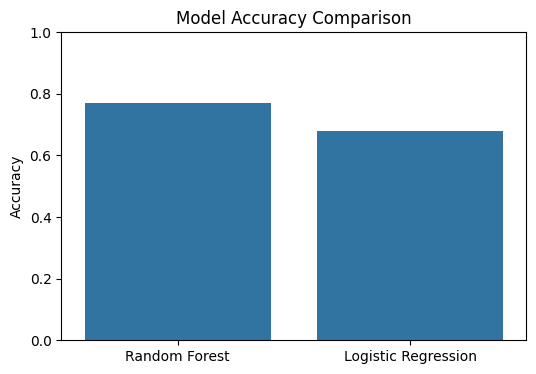

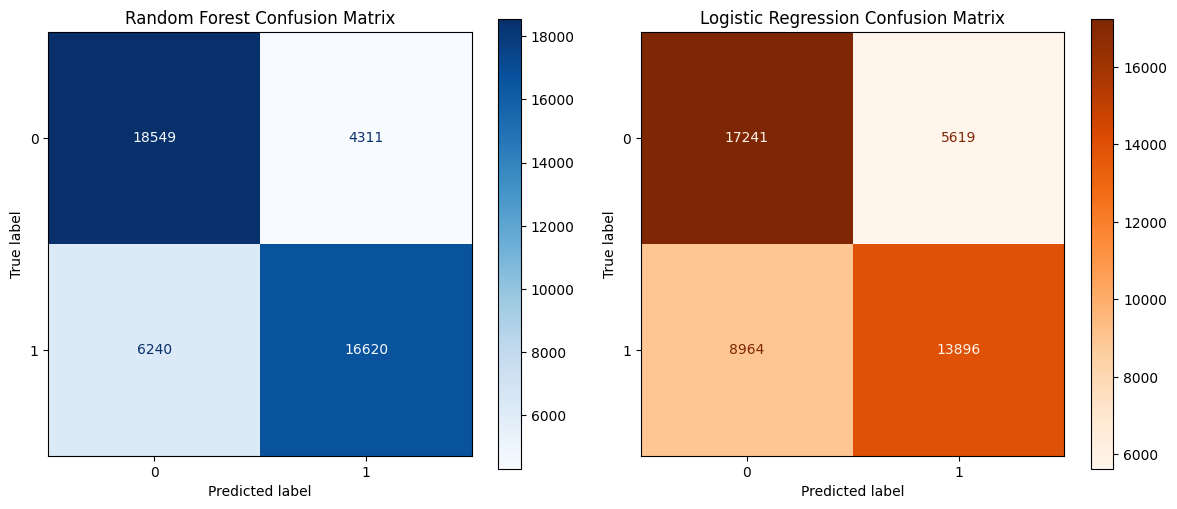

In [39]:
# Accuracy comparison
models = ['Random Forest', 'Logistic Regression']
accuracies = [rf_acc, log_acc]

plt.figure(figsize=(6,4))
sns.barplot(x=models, y=accuracies)
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()

# Confusion Matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=axes[0], cmap='Blues')
axes[0].set_title('Random Forest Confusion Matrix')

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_log, ax=axes[1], cmap='Oranges')
axes[1].set_title('Logistic Regression Confusion Matrix')

plt.tight_layout()
plt.show()
